C:\Users\marsh\AppData\Local\Temp\ipykernel_29464\1792218931.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model_1['power'] = data_model_1['Voltage solar panel'] * data_model_1['Current Solar panel']


Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 0.0098 - val_loss: 0.0085
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - val_loss: 0.0068
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0018 - val_loss: 0.0053
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 8.8185e-04 - val_loss: 0.0018
Epoch 8/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.9544e-04 - val_loss: 0.0010
Epoch 9/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.7677e-04 - val_loss: 9.3405e-04
Epoch 10/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.5173e-04 - val_loss: 9.4107e-04
Epoch 11/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.5679e-04 - val_loss: 0.0010
Epoch 12/50
102

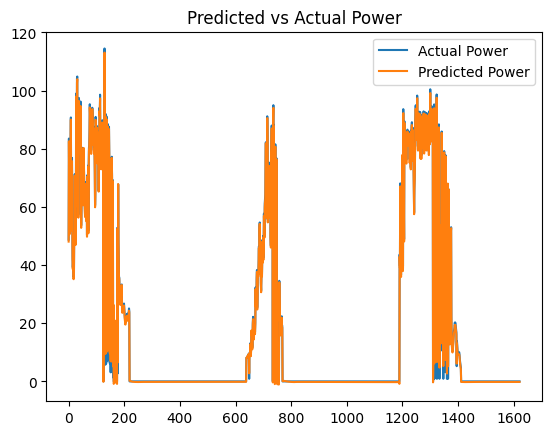

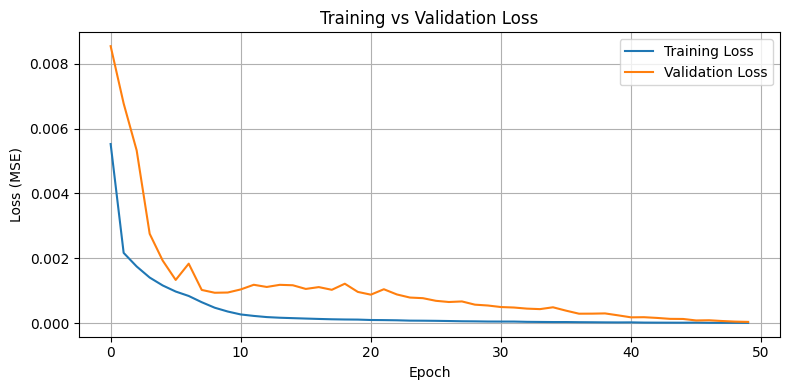

Mean Squared Error (MSE) untuk Model LSTM: 0.5962559582230881


In [1]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Langkah 1: Memuat data
file_path = 'data_valid_for_LSTM.csv'
data = pd.read_csv(file_path)

# Langkah 2: Tangani NaN dan Infinity
numeric_columns = data.select_dtypes(include=[np.number])
data[numeric_columns.columns] = numeric_columns.apply(
    lambda x: np.nan_to_num(x, nan=0.001, posinf=0.001, neginf=0.001)
)

# Langkah 3: Konversi 'created_at' menjadi datetime
data['created_at'] = pd.to_datetime(data['created_at'])

# Langkah 4: Filter data nilai 0 dan jam operasional
data['hour'] = data['created_at'].dt.hour
filtered_data = data[~((data['Voltage solar panel'] == 0) | (data['Current Solar panel'] == 0)) | 
                     ((data['hour'] < 7) | (data['hour'] >= 17))]

# Langkah 5: Filter berdasarkan tanggal
start_date = '2025-05-15'
end_date = '2025-06-29'
data_model_1 = filtered_data[(filtered_data['created_at'] >= start_date) & (filtered_data['created_at'] <= end_date)]

# Langkah 6: Tangani nilai negatif
columns_to_fix = ['irradiance', 'light intensity', 'Current Solar panel']
for col in columns_to_fix:
    data_model_1.loc[:, col] = data_model_1[col].apply(lambda x: 0.001 if x < 0 else x)

# Langkah 7: Persiapan data tanpa fitur Humidity
features = ['temperature', 'irradiance', 'light intensity', 'Voltage solar panel', 'Current Solar panel']
data_model_1['power'] = data_model_1['Voltage solar panel'] * data_model_1['Current Solar panel']
target = 'power'

X = data_model_1[features].values
y = data_model_1[target].values

# Langkah 8: Normalisasi
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Langkah 9: Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

# Langkah 10: Reshape untuk LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Langkah 11: Hyperparameter dan model
epochs = 50
batch_size = 64
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dense(units=1))

# Langkah 12: Compile dan fit model
model.compile(optimizer=optimizer, loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

# Langkah 13: Prediksi dan evaluasi
y_pred = model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)

# Grafik Predicted vs Actual
plt.plot(scaler_y.inverse_transform(y_test), label='Actual Power')
plt.plot(y_pred_rescaled, label='Predicted Power')
plt.legend()
plt.title('Predicted vs Actual Power')
plt.show()

# Grafik Training vs Validation Loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluasi MSE
mse = mean_squared_error(scaler_y.inverse_transform(y_test), y_pred_rescaled)
print(f'Mean Squared Error (MSE) untuk Model LSTM: {mse}')

In [2]:
# Simpan model LSTM
model.save('model_lstm_power_V1.h5')
print("✅ Model berhasil disimpan sebagai 'model_lstm_power_V1.h5'.")

# Simpan scaler menggunakan joblib
import joblib
joblib.dump(scaler_X, 'scaler_X_no_humidity.save')
joblib.dump(scaler_y, 'scaler_y_no_humidity.save')
print("✅ Scaler_X dan Scaler_Y berhasil disimpan.")


from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

y_actual = scaler_y.inverse_transform(y_test)
y_predicted = y_pred_rescaled

mae = mean_absolute_error(y_actual, y_predicted)
rmse = np.sqrt(mse)
r2 = r2_score(y_actual, y_predicted)

print(f"📊 Evaluasi Tambahan:")
print(f"🔹 Mean Absolute Error (MAE): {mae}")
print(f"🔹 Root Mean Squared Error (RMSE): {rmse}")
print(f"🔹 R² Score: {r2}")


✅ Model berhasil disimpan sebagai 'model_lstm_power_V1.h5'.
✅ Scaler_X dan Scaler_Y berhasil disimpan.
📊 Evaluasi Tambahan:
🔹 Mean Absolute Error (MAE): 0.44889196281096577
🔹 Root Mean Squared Error (RMSE): 0.7721761186562869
🔹 R² Score: 0.9993819675466481


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


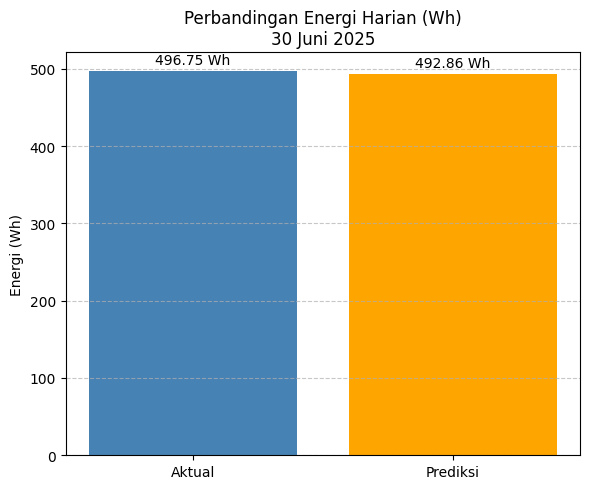

Total Energi Aktual  : 496.75 Wh
Total Energi Prediksi: 492.86 Wh


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import joblib

# Load model dan scaler
model = load_model('model_lstm_power_V1.h5')
scaler_X = joblib.load('scaler_X_no_humidity.save')
scaler_y = joblib.load('scaler_y_no_humidity.save')

# Load dan olah data
file_path = 'data_valid_for_LSTM.csv'
data = pd.read_csv(file_path)
data['created_at'] = pd.to_datetime(data['created_at'])

# Filter data tanggal 30 Juni 2025
data_30_juni = data[data['created_at'].dt.date == pd.to_datetime('2025-06-30').date()].copy()

# Tangani nilai negatif
columns_to_fix = ['irradiance', 'light intensity', 'Current Solar panel']
for col in columns_to_fix:
    data_30_juni.loc[:, col] = data_30_juni[col].apply(lambda x: 0.001 if x < 0 else x)

# Tangani nilai nol saat siang hari (jam 07.00–17.00)
data_30_juni.loc[:, 'hour'] = data_30_juni['created_at'].dt.hour
data_30_juni = data_30_juni[~(((data_30_juni['Voltage solar panel'] == 0) | 
                               (data_30_juni['Current Solar panel'] == 0)) & 
                              ((data_30_juni['hour'] >= 7) & (data_30_juni['hour'] < 17)))]

# Hitung power aktual
data_30_juni['power'] = data_30_juni['Voltage solar panel'] * data_30_juni['Current Solar panel']

# Cek jika tidak ada data
if data_30_juni.empty:
    raise ValueError("Data tanggal 30 Juni 2025 kosong setelah penyaringan. Silakan periksa sumber data.")

# Fitur input (tanpa Humidity)
features = ['temperature', 'irradiance', 'light intensity', 'Voltage solar panel', 'Current Solar panel']
X_30 = data_30_juni[features].values

# Normalisasi dan reshape
X_30_scaled = scaler_X.transform(X_30)
X_30_scaled = X_30_scaled.reshape((X_30_scaled.shape[0], 1, X_30_scaled.shape[1]))

# Prediksi
y_pred_scaled = model.predict(X_30_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

# Hitung energi Wh (interval 2 menit = 1/30 jam)
data_30_juni['Predicted Power'] = y_pred
data_30_juni['Actual Energy_Wh'] = data_30_juni['power'] * (1/30)
data_30_juni['Predicted Energy_Wh'] = data_30_juni['Predicted Power'] * (1/30)

# Total energi
total_actual_energy_wh = data_30_juni['Actual Energy_Wh'].sum()
total_predicted_energy_wh = data_30_juni['Predicted Energy_Wh'].sum()

# Plot perbandingan bar
labels = ['Aktual', 'Prediksi']
energi_wh = [total_actual_energy_wh, total_predicted_energy_wh]

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, energi_wh, color=['steelblue', 'orange'])
plt.title('Perbandingan Energi Harian (Wh)\n30 Juni 2025')
plt.ylabel('Energi (Wh)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 5, f'{height:.2f} Wh', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Cetak hasil
print(f"Total Energi Aktual  : {total_actual_energy_wh:.2f} Wh")
print(f"Total Energi Prediksi: {total_predicted_energy_wh:.2f} Wh")
